In [1]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import imageio
import matplotlib.image as mpimg
import tifffile
from torch import nn
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from utils import *
from datasets import *
import torch.nn.functional as Func
import torch

In [2]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([[0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
                        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
                        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
                        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
                        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
                        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353]]
                            )

In [3]:
import math

def calculate_window_positions(image_width, image_height, window_size, step_size):
    window_positions = []

    # Calculate the number of passes in horizontal and vertical directions
    horizontal_passes = math.floor((image_width - window_size) / step_size) + 1
    vertical_passes = math.floor((image_height - window_size) / step_size) + 1

    # Iterate over each pass
    for i in range(vertical_passes):
        for j in range(horizontal_passes):
            # Calculate the initial position of the window
            start_x = j * step_size
            start_y = i * step_size

            # Calculate the final position of the window
            end_x = start_x + window_size
            end_y = start_y + window_size

            # window_positions.append(((start_x, start_y), (end_x, end_y)))
            window_positions.append((start_x, start_y))

    return window_positions

In [4]:
data_filename = "data/images/train/"
mask_filename = "data/annotations/train/"

In [5]:
file = "il_0"

teste = get_input_data(data_filename + file + ".tif")
mask = load_image(mask_filename + file + ".png")

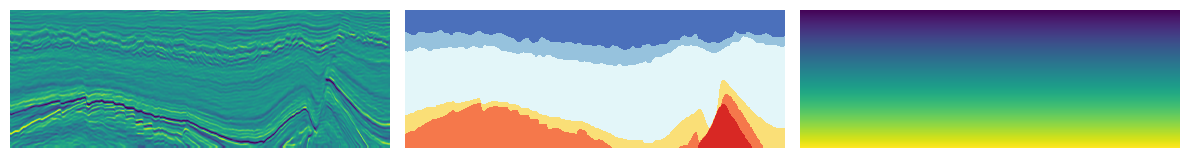

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(teste[:,:,0])
axs[1].imshow(mask, cmap=cmap)
axs[2].imshow(teste[:,:,1])

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [7]:
data_dir = "data/images/train"
mask_dir = "data/annotations/train"

dataset = BasicDataset(data_dir=data_dir, mask_dir=mask_dir, augmentation=True) 

  0%|          | 0/992 [00:00<?, ?it/s]

100%|██████████| 992/992 [00:00<00:00, 3082.20it/s]


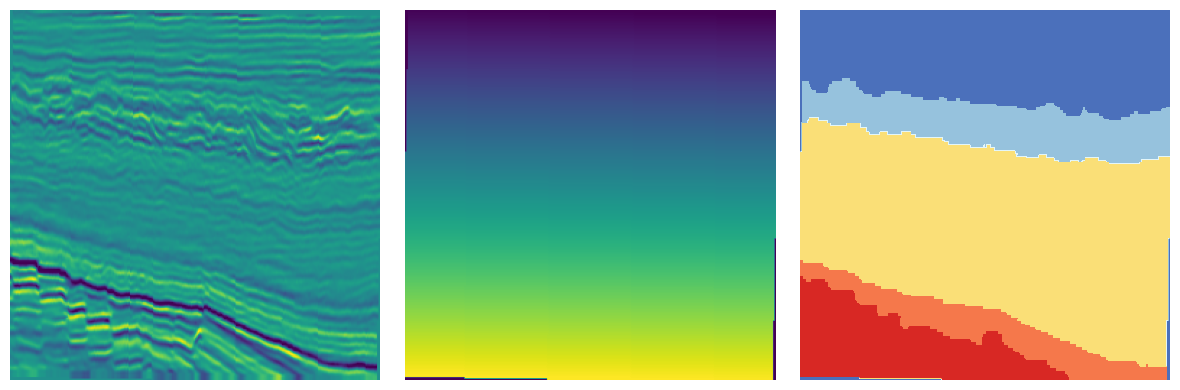

In [41]:
idx = random.randint(0, len(dataset))

instancia = dataset[idx]

data_teste, mask_teste = instancia['image'], instancia['mask']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(data_teste[0,:,:])
axs[1].imshow(data_teste[1,:,:])
axs[2].imshow(mask_teste, cmap=cmap)

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from torch.utils.data import DataLoader
import os

In [10]:
train_dir = 'data/images/train'
train_mask_dir = 'data/annotations/train'
val_dir = 'data/images/val'
val_mask_dir = 'data/annotations/val'
checkpoint_dir = 'checkpoints/'

In [11]:
loader_args = dict(batch_size = 16, num_workers = os.cpu_count(), pin_memory = True)
train_loader = DataLoader(dataset, shuffle = True, **loader_args)

In [12]:
len(train_loader)

62

In [13]:
first_batch = next(iter(train_loader))
len(first_batch)

2

In [14]:
element1 = first_batch['image']
element2 = first_batch['mask']
element1.shape, element2.shape

(torch.Size([16, 2, 256, 256]), torch.Size([16, 256, 256]))

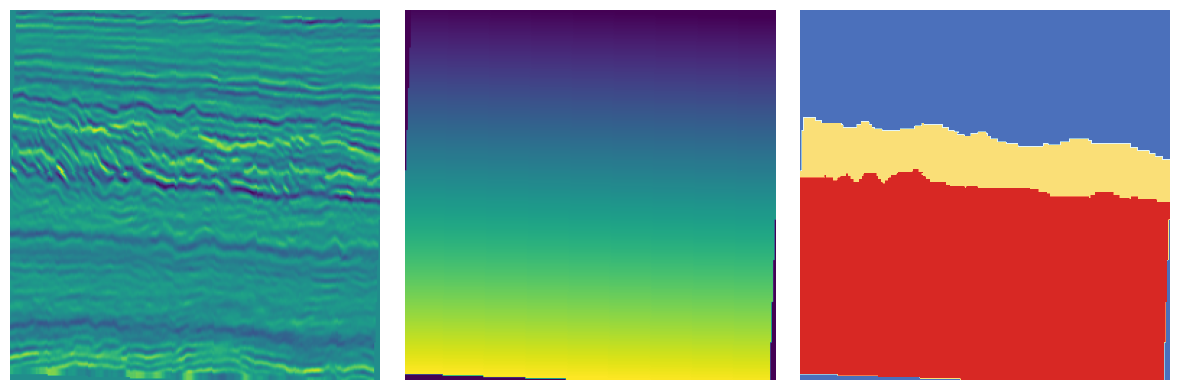

In [15]:
idx = random.randint(0, 16)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(element1[idx][0])
axs[1].imshow(element1[idx][1])
axs[2].imshow(element2[idx], cmap=cmap)

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
from datasets import *

In [17]:
dataset_no_transform = BasicDataset(data_dir=data_dir, mask_dir=mask_dir, augmentation=False)

  0%|          | 0/992 [00:00<?, ?it/s]

100%|██████████| 992/992 [00:00<00:00, 2963.25it/s]


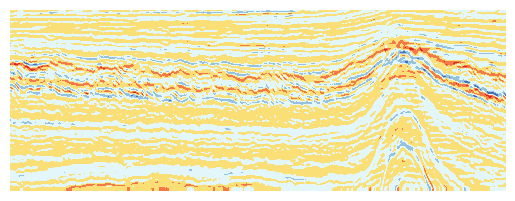

In [18]:
from torchvision.transforms import functional as F

idx = random.randint(0, len(dataset_no_transform)-1)
instancia_no_transform = dataset_no_transform[idx]
image = instancia_no_transform['image']

i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
# image = TF.crop(image, i, j, h, w)
i, j, h, w

plt.imshow(image[0], cmap=cmap)
plt.axis('off')
plt.show()

In [19]:
# image = torch.rand(1, 256, 701)

In [20]:
image.shape

torch.Size([2, 256, 701])

In [21]:
image = TF.pad(image, padding=(128, 0, 128, 0), padding_mode='reflect')

In [22]:
image.shape

torch.Size([2, 256, 957])

In [23]:
image_width = image.shape[2]
image_height = image.shape[1]
window_size = 256
step_size = 32

window_positions = calculate_window_positions(image_width, image_height, window_size, step_size)
image_height, image_width

(256, 957)

In [24]:
from torchvision.transforms import functional as TF


crops = []
patch_size = 256

for (x, y) in window_positions:
    crop = image[:, y:y+patch_size, x:x+patch_size]
    crops.append(crop)


crops[0].shape, image.shape

(torch.Size([2, 256, 256]), torch.Size([2, 256, 957]))

In [25]:
len(crops)

22

torch.Size([2, 256, 957])

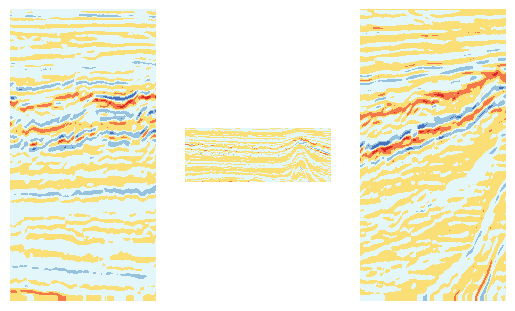

In [26]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(image[0, :, :128], cmap=cmap)
axs[0].axis('off')

axs[1].imshow(image[0, :, 128:701+128], cmap=cmap)
axs[1].axis('off')

axs[2].imshow(image[0, :, 701+128:], cmap=cmap)
axs[2].axis('off')

image.shape

(-0.5, 956.5, 255.5, -0.5)

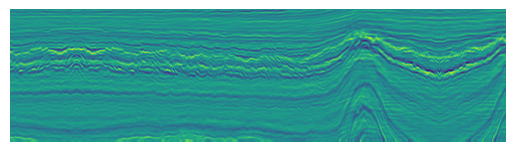

In [27]:
# plt.imshow(image[0], cmap=cmap)
plt.imshow(image[0])
plt.axis('off')

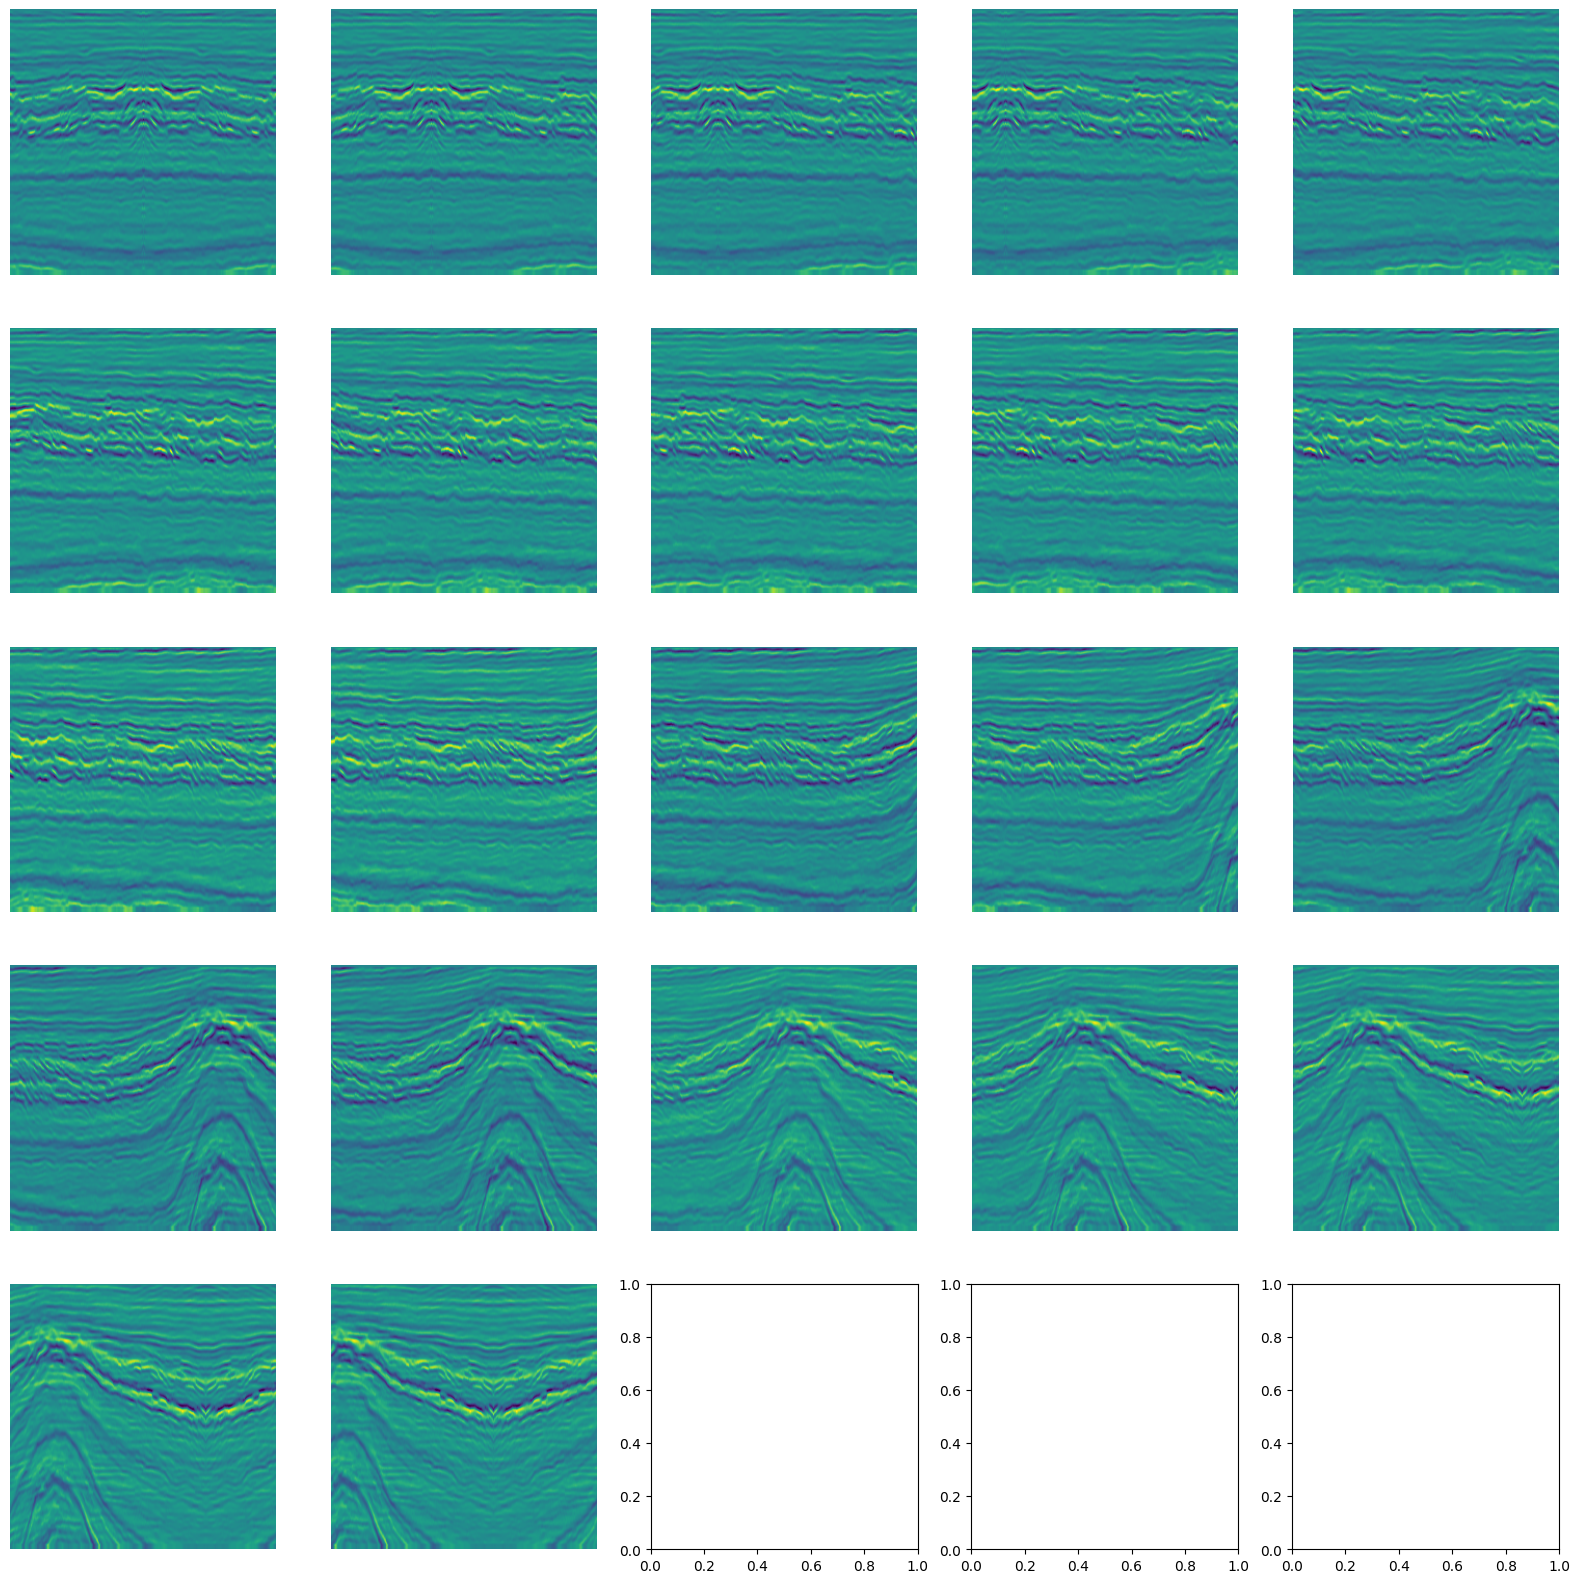

In [28]:
num_cols = 5
num_rols = int(np.ceil(len(crops)/num_cols))

fix, axs = plt.subplots(num_rols, num_cols, figsize=(20, 20))

for i, crop in enumerate(crops):
    row = i // num_cols
    col = i % num_cols
    # axs[row, col].imshow(crop[0], cmap=cmap)
    axs[row, col].imshow(crop[0])
    axs[row, col].axis('off')

# plt.tight_layout()


In [29]:
mask.shape

(255, 701)

In [30]:
mask_values = [0, 1, 2, 3, 4, 5]

In [31]:
image

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0208,  0.0182,  0.0067,  ...,  0.0238,  0.0248,  0.0329],
         [ 0.0919,  0.0842,  0.0347,  ...,  0.1360,  0.1406,  0.1809],
         ...,
         [ 0.2509,  0.2174,  0.1924,  ...,  0.0284,  0.0180, -0.0125],
         [ 0.2509,  0.2174,  0.1924,  ...,  0.0284,  0.0180, -0.0125],
         [ 0.2509,  0.2174,  0.1924,  ...,  0.0284,  0.0180, -0.0125]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0039,  0.0039,  0.0039,  ...,  0.0039,  0.0039,  0.0039],
         [ 0.0079,  0.0079,  0.0079,  ...,  0.0079,  0.0079,  0.0079],
         ...,
         [ 0.9961,  0.9961,  0.9961,  ...,  0.9961,  0.9961,  0.9961],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],
       dtype=torch.float64)

In [32]:
# tensor_mask = torch.from_numpy(image)
tensor_mask = image
tensor_mask.shape

torch.Size([2, 256, 957])

In [33]:
mask_teste = Func.one_hot(tensor_mask.to(torch.int64), len(mask_values))

RuntimeError: Class values must be non-negative.

In [ ]:
# mask_teste = mask_teste.permute(2, 0, 1)
mask_teste = mask_teste.permute(0, 3, 1, 2)
mask_teste.shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

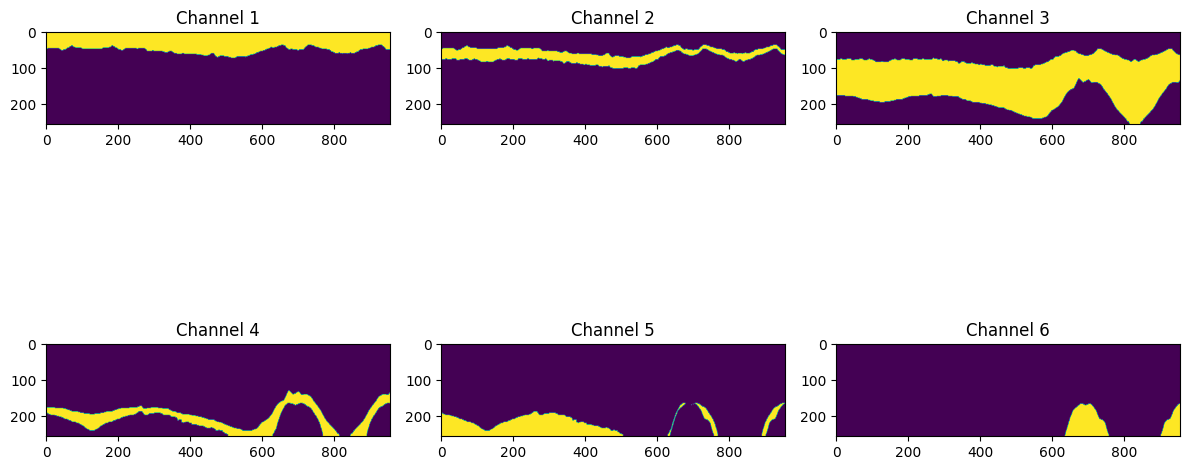

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, channel in enumerate(mask_teste[0]):
    axs[i].imshow(channel)
    axs[i].set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()


In [ ]:
def reconstruct_image(list_coords, list_images, n_classes, out_height, out_width):
    
    image_size = list_images[0].shape[1]
    out_image = np.zeros((out_height, out_width, n_classes))
    
    for i, (x, y) in enumerate(list_coords):
        temp = Func.one_hot(torch.tensor(list_images[i]).to(torch.int64), n_classes)
        aux = np.add(out_image[y:y+image_size, x:x+image_size], temp)
        out_image[y:y+image_size, x:x+image_size] = aux
        
    return torch.from_numpy(out_image.transpose(2, 0, 1))

In [ ]:
out_image = reconstruct_image(window_positions, crops, 6, image_height, image_width)
out_image.argmax(0)

C:\Users\vilem\AppData\Local\Temp\ipykernel_13888\1415803397.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = Func.one_hot(torch.tensor(list_images[i]).to(torch.int64), n_classes)


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0]])

(<matplotlib.image.AxesImage at 0x29829d758a0>, torch.Size([256, 701]))

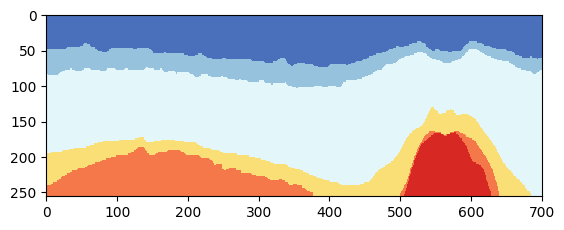

In [ ]:
out_image_cropped = out_image.argmax(0)[:,128:-128]
plt.imshow(out_image_cropped, cmap=cmap), out_image_cropped.shape

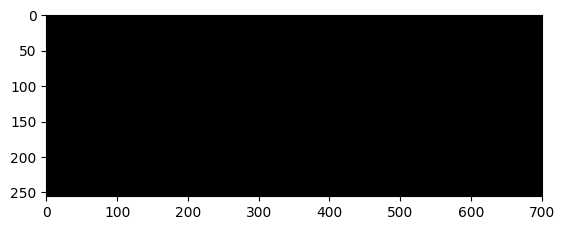

In [ ]:
image_cropped = image[0,:,128:701+128]
plt.imshow(out_image_cropped - image_cropped, cmap='gray')


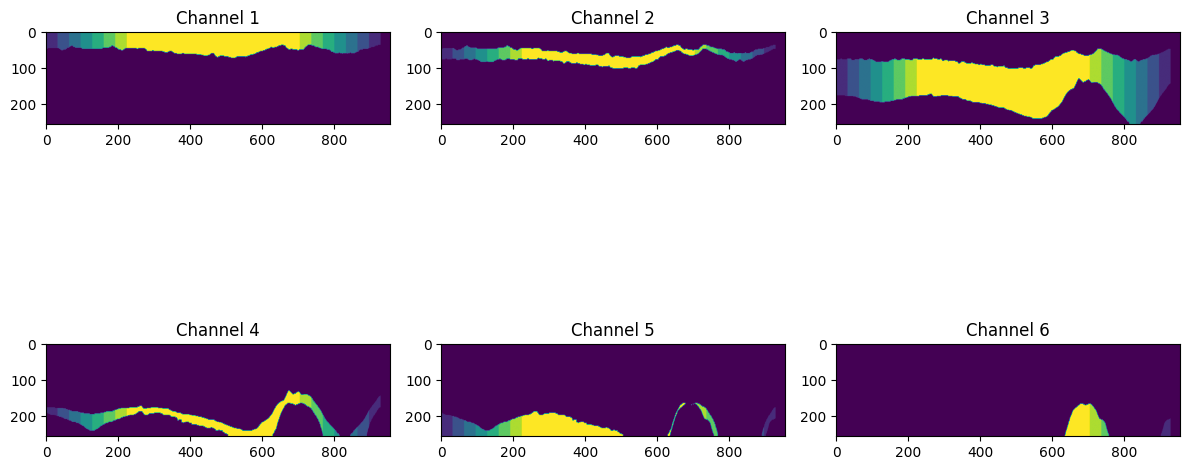

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, channel in enumerate(out_image):
    axs[i].imshow(channel)
    axs[i].set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()
